<h1>Lab Five: Wide and Deep Networks</h1>
<b>By Michael Watts, Maya Muralidhar, Nora Potenti, and Adam Ashcraft </b>

<h2> 1.0 Preparation </h2>

<h3> 1.1 Business Understanding </h3>

Our data set for this lab is a collection of synthetic online transactions produced by The PaySim simulator and collected by the Norwegian University of Science and Technology. The simulation was created based on real financial data for a multinational company. It is categorized by the type of the transaction (i.e. a payment, transfer, etc.), the original balance before and after the transaction of the source account, the balance before and after the transaction of the destination account, and if the transaction was actually fraud. It is also marked by several other categories not useful for this use case. As more and more transactions shift from the physical space to the digital space, it becomes more important for financial institutions to be able to detect and deny fraudulent charges. As the number of digital transactions increases, the amount of data to parse to determine the legitimacy of a transaction increases to the point where these companies could not afford humans to do the fraud detection. This is where our model would come in, as an efficient learning tool able to detect and mark fraud for these institutions. Romexsoft, a company that helps develop fraud detection models, boast a 98% fraud detection rate. For our model to be a success, it must detect at or above this rate. 
<hr>
Kaggle link: https://www.kaggle.com/ntnu-testimon/paysim1/home  <br>
Romexsoft: https://www.romexsoft.com/blog/credit-card-fraud-detection-in-banking/

<h3> 1.2 Data Cleaning </h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pickle
import warnings
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from scipy.special import expit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import missingno as mn
import sys

In [2]:
finData = pd.read_csv('data/PS_20174392719_1491204439457_log.csv') #load the data
finData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Let's begin by removing some of the columns we will not be using. After this, we will convert the oldbalanceOrg and newbalanceOrig into one column that reflects the change the original account balance, called Org_Account_Delta. If it is an increase in account balance, we will make it a 1. If it is a decrease we will make it a negative 1. No change will be a 0. We will do the same thing for oldbalanceDest and newbalanceDest in Dest_Account_Delta. Finally, we will encode the one-hot encode the 6 types: CASH-IN, CASH-OUT, NAN, DEBIT, PAYMENT and TRANSFER. If a transaction is fraudulent, in the isFraud column, it will be marked as 1.

In [3]:
finData.drop(columns=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)
def calcChange1(change):
    #change = row.newbalanceOrig - row.oldbalanceOrg
    if(change > 0):
        return 'positive'
    if(change < 0):
        return 'negative'
    if(change == 0):
        return 'zero'
def calcChange2(change):
    #change = row.newbalanceDest - row.oldbalanceDest
    if(change > 0):
        return 'positive'
    if(change < 0):
        return 'negative'
    if(change == 0):
        return 'zero'
finData['Org_Account_Delta'] = finData['newbalanceOrig']-finData['oldbalanceOrg']
finData['Dest_Account_Delta'] = finData['newbalanceDest']-finData['oldbalanceDest']
finData['Org_Account_Delta'] = finData['Org_Account_Delta'].apply(lambda x: calcChange1(x))
finData['Dest_Account_Delta'] = finData['Dest_Account_Delta'].apply(lambda x: calcChange2(x))
finData.drop(columns=['newbalanceOrig', 'newbalanceDest'], inplace=True)
finData.head()

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,Org_Account_Delta,Dest_Account_Delta
0,PAYMENT,9839.64,170136.0,0.0,0,negative,zero
1,PAYMENT,1864.28,21249.0,0.0,0,negative,zero
2,TRANSFER,181.00,181.0,0.0,1,negative,zero
3,CASH_OUT,181.00,181.0,21182.0,1,negative,negative
4,PAYMENT,11668.14,41554.0,0.0,0,negative,zero


Now let's pickle our data for faster reterival. 

In [4]:
pickle.dump(finData, open( 'pickledData/finData.p', 'wb' ))

In [5]:
finData = pickle.load(open( 'pickledData/finData.p', 'rb' ))

In [6]:
finData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
type                  object
amount                float64
oldbalanceOrg         float64
oldbalanceDest        float64
isFraud               int64
Org_Account_Delta     object
Dest_Account_Delta    object
dtypes: float64(3), int64(1), object(3)
memory usage: 339.8+ MB


<module 'missingno' from 'C:\\Users\\mayam\\Anaconda3\\lib\\site-packages\\missingno\\__init__.py'>


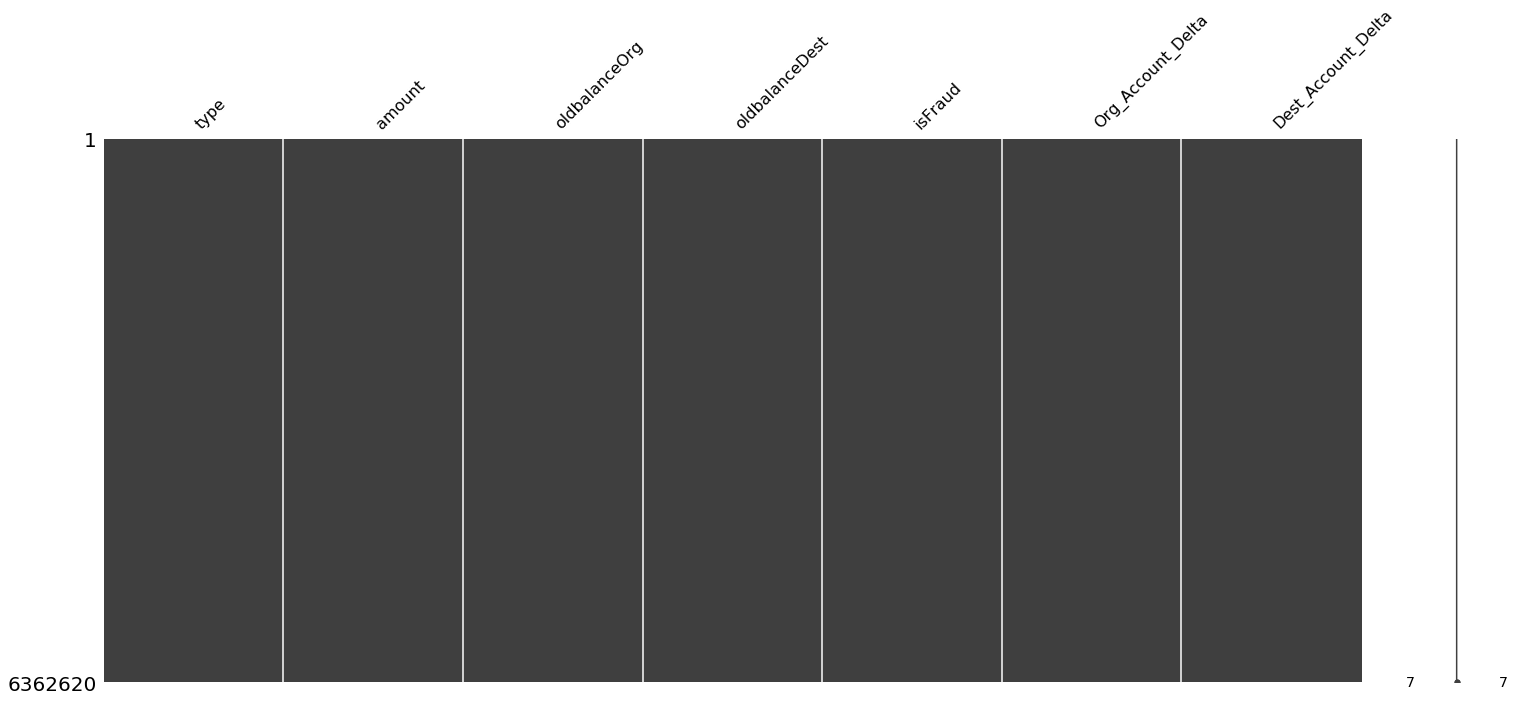

In [7]:
mn.matrix(finData)
print(mn)

We now have no missing data that needs to be imputed. We have our Y target, isFraud. We also have the type of transaction and the amount of each transaction. We have generated columns to show the change in each account with each transaction as well. Finally, we also know the account balance for the origin and destination accounts before each transaction. 

<h3> 1.3 Cross-Product Features </h3>

First we will cross Dest_Account_Delta and type. This could reveal a correlation between the type of transaction used money being sent into a destination account. If scammers found a method to execute a certain kind of transaction on customer accounts, they would use the same transaction type over and over to extract money from a customer account into their own.  Next we will cross Org_Account_Delta and type. This will help us establish the same kind of correlation from the previous column cross. It will however also reveal to us possible correlations where scammers are directly drawing from customer accounts without using a secondary account. Logically scammers would try this method as much as possible, as it does not involve adding a secondary account with a paper trail that could possibly lead back to them. If these kinds of fraudulent transactions are common, this cross will reveal it. Finally, we will cross Dest_Account_Delta and Org_Account_Delta. This will help further learn the correlation between when money leaves a customer account and ends up in a new account. Untimely this will help further cement either the correlation between a high number of direct fraudulent withdraws, or fraudulent money transfers.     

 


In [8]:
cross_product_sets= [['type', 'Dest_Account_Delta'], 
                     [ 'type', 'Org_Account_Delta'], 
                    ['Dest_Account_Delta', 'Org_Account_Delta']]

<h3> 1.4 Evaluation Criteria </h3>

For our evaluation criteria, we will be focused on recall. Recall focuses on the amount of false negatives achieved. In this instance a false negative means marking a fraudulent transaction as a genuine one. A false positive means we have marked a genuine transaction as a fraudulent one. In a false positive scenario, the client may be slightly inconvenienced. He would have to call the bank and ensure the proper funds are released. In a false negative situation, the client’s money has been illegally transferred from his account and is most likely lost to him forever. The bank will have to spend time both reimbursing his account and filing the proper paperwork about the fraudulent attempt. The client will be unhappy the bank has not properly secured his money and the criminal has just successful conned the bank. In order to prevent what would be the worse case scenario for a mislabeled transaction, we will focus on keeping our recall and subsequently our false negative rate low.


In [9]:
my_scorer = make_scorer(recall_score)

<h3> 1.5 Data Division <h3>

For our data, we will use a stratified shuffle split. The stratification of the data ensures that each k-fold will have the same percentage of fraudulent data as the data set as a whole. This prevents the model from ever receiving and being trained off of a data set with no fraudulent transactions present. If this were the case, our network may simply detect everything as genuine and still have a good evaluation score. shuffling will prevent any one account from being disproportionally present in a fold. As this data was originally linear time data, it is possible one account would be making several hundreds of transactions sequentially. For instance, a company may be restocking all its inventory at once. To avoid this, we will shuffle the data. While 10 splits would have been the best choice, for the sake of computation, we will bound it with 5 folds. 


In [10]:
# Undersample
sampledFinData = pd.concat([finData.loc[finData['isFraud']==0].sample(frac=.01), finData.loc[finData['isFraud']==1]])
sampledFinData.shape

(71757, 7)

In [11]:
#first we will divide out our X and Y data
y = sampledFinData.isFraud
finData.drop(columns=['isFraud'], inplace=True)
X = sampledFinData
cv = StratifiedShuffleSplit(n_splits=5, random_state=1) 
print(y.shape)
print(X.shape)

(71757,)
(71757, 7)


<br><h2> 2.0 Modeling </h2>

<h3> 2.1 Train/Test/Split to Divide Data </h3>

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.layers import concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scipy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train_ints = X_train.copy()
X_test_ints = X_test.copy()
print(X_train.shape)

categorical_headers = ['type', 'Org_Account_Delta', 'Dest_Account_Delta']
numeric_headers = ['amount', 'oldbalanceOrg', 'oldbalanceDest']

# standard scale numeric columns
for col in numeric_headers:
    X_train[col] = X_train[col].astype(np.float)
    X_test[col] = X_test[col].astype(np.float)
    
    ss = StandardScaler()
    X_train[col] = ss.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = ss.transform(X_test[col].values.reshape(-1, 1))
    

for col in ['type', 'Org_Account_Delta', 'Dest_Account_Delta']:
    train_labels, train_levels = pd.factorize(X_train[col])
    test_labels, test_levels = pd.factorize(X_test[col])
    X_train_ints[col] = train_labels
    X_test_ints[col] = test_labels
    
ohe = OneHotEncoder()    
X_train_ohe = ohe.fit_transform(X_train_ints[['type', 'Org_Account_Delta', 'Dest_Account_Delta']].values)
X_test_ohe = ohe.transform(X_test_ints[['type', 'Org_Account_Delta', 'Dest_Account_Delta']].values)

X_train_num =  X_train[['amount', 'oldbalanceOrg', 'oldbalanceDest']].values
X_test_num = X_test[['amount', 'oldbalanceOrg', 'oldbalanceDest']].values
#X_train = X_train.values
#X_test = X_test.values
#y_train = y_train.values
#y_test = y_test.values

C:\Users\mayam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(57405, 7)


C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [13]:
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
# From Stack Overflow: 
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper


In [14]:
def get_x_ints(crossed_columns, X_train_t, X_test_t):
    X_ints_train = [] # keep track of inputs for each branch
    X_ints_test = []
    X_train_ints = X_train_t.copy()
    X_test_ints = X_test_t.copy()
    enc = LabelEncoder()
    for cols in crossed_columns:
        X_crossed_train = X_train_t[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = X_test_t[cols].apply(lambda x: '_'.join(x), axis=1)
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )
    for col in ['type', 'Org_Account_Delta', 'Dest_Account_Delta']:
        train_labels, train_levels = pd.factorize(X_train_t[col])
        test_labels, test_levels = pd.factorize(X_test_t[col])
        X_train_ints[col] = train_labels
        X_test_ints[col] = test_labels
    for col in categorical_headers:
        X_ints_train.append( X_train_ints[col].values )
        X_ints_test.append( X_test_ints[col].values )
    return  X_ints_train, X_ints_test

In [15]:
def create_model(crossed_columns, num_deep_layers, X_train, X_test):
    X_ints_train = [] # keep track of inputs for each branch
    X_ints_test = []# keep track of inputs for each branch
    all_inputs = [] # this is what we will give to keras.Model inputs
    all_branch_outputs = [] # this is where we will keep track of output of each branch
    all_wide_branch_outputs = []
    all_deep_branch_outputs = []
    for cols in crossed_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    
    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    for col in categorical_headers:
        # encode as ints for the embedding
        X_ints_train.append( X_train_ints[col].values )
        X_ints_test.append( X_test_ints[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)
    
    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='tanh',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )
    
    #x = concatenate([xSparse, xDense], name='concat')
    #all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    if(num_deep_layers >= 1):
        deep_branch = Dense(units=6,activation='tanh', name='deep1')(deep_branch)
        print('Deep 1 created') # just to check
    if(num_deep_layers > 1):
        deep_branch = Dense(units=3,activation='tanh', name='deep2')(deep_branch)
        print('Deep 2 created') # just to check
    if(num_deep_layers > 2):
        deep_branch = Dense(units=3,activation='tanh', name='deep3')(deep_branch)
        print('Deep 3 created') # just to check    
    
    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    # a layer instance is callable on a tensor, and returns a tensor
    final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)
    model = Model(inputs=all_inputs, outputs=final_branch)
    model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[as_keras_metric(tf.metrics.recall), 'accuracy'])
    return model

In [16]:
crossed_product_sets_1 = cross_product_sets[:2]
X_ints_train, X_ints_test = get_x_ints(crossed_product_sets_1, X_train, X_test)


In [17]:
network_1 = KerasClassifier(build_fn=create_model,
                        crossed_columns=crossed_product_sets_1,
                        num_deep_layers=2,
                        X_train=X_train,
                        X_test=X_test,
                        epochs=5, 
                        batch_size=100,
                        verbose=1,)

In [18]:
X_ints_train.append(X_train_num)
X_ints_test.append(X_test_num)

In [19]:
model_1_performance = network_1.fit(X_ints_train, y_train, validation_data = (X_ints_test, y_test))
#results = cross_val_score(network_1, X, y, cv=cv)

Deep 1 created
Deep 2 created
Train on 57405 samples, validate on 14352 samples
Epoch 1/5
57405/57405 [==============================] - 4s 61us/step - loss: 0.1195 - recall: 0.9983 - acc: 0.8852 - val_loss: 0.0968 - val_recall: 1.0000 - val_acc: 0.8868
Epoch 2/5
57405/57405 [==============================] - 2s 43us/step - loss: 0.0930 - recall: 1.0000 - acc: 0.8852 - val_loss: 0.0892 - val_recall: 1.0000 - val_acc: 0.8870
Epoch 3/5
57405/57405 [==============================] - 2s 42us/step - loss: 0.0875 - recall: 1.0000 - acc: 0.8915 - val_loss: 0.0850 - val_recall: 1.0000 - val_acc: 0.8990
Epoch 4/5
57405/57405 [==============================] - 2s 42us/step - loss: 0.0837 - recall: 1.0000 - acc: 0.9006 - val_loss: 0.0820 - val_recall: 1.0000 - val_acc: 0.9044
Epoch 5/5
57405/57405 [==============================] - 2s 43us/step - loss: 0.0809 - recall: 1.0000 - acc: 0.9048 - val_loss: 0.0797 - val_recall: 1.0000 - val_acc: 0.9067


Text(0.5,0,'epochs')

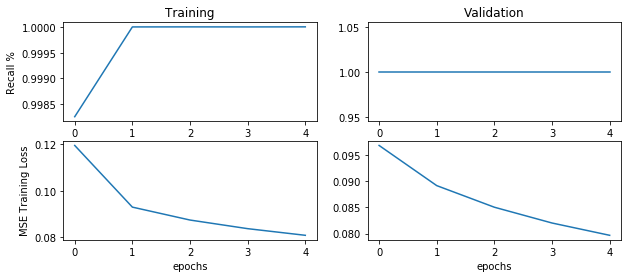

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(model_1_performance.history['recall'])
plt.ylabel('Recall %')

plt.title('Training')
plt.subplot(2,2,2)
plt.plot(model_1_performance.history['val_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(model_1_performance.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(model_1_performance.history['val_loss'])
plt.xlabel('epochs')

<h3> 2.2 Stratified Shuffle Split </h3>

In [21]:
#X_train_set = []
#X_test_set = []
#y_train_set = []
#y_test_set = []


#for train_index, test_index in cv.split(X, y): 
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#    y_train_set.append(y_train)
#    y_test_set.append(y_test)

#print(X_train.shape)
#print(X_test.shape)

In [22]:
# 
# standard scale numerical headers    
#for each in numeric_headers:
#    X_train[each] = X_train[each].astype(np.float)
#    X_test[each] = X_test[each].astype(np.float)
    
#    ss = StandardScaler()
#    X_train[each] = ss.fit_transform(X_train[each].values.reshape(-1, 1))
#    X_test[each] = ss.transform(X_test[each].values.reshape(-1, 1))

In [23]:
crossed_product_sets_2 = cross_product_sets
X_ints_train_2, X_ints_test_2 = get_x_ints(crossed_product_sets_2, X_train, X_test)
X_ints_train_2.append(X_train_num)
X_ints_test_2.append(X_test_num)

In [24]:
network_2 = KerasClassifier(build_fn=create_model,
                        crossed_columns=crossed_product_sets_2,
                        num_deep_layers=3,
                        X_train=X_train,
                        X_test=X_test,
                        epochs=5, 
                        batch_size=100,
                        verbose=1,)

In [25]:
model_2_performance = network_2.fit(X_ints_train_2, y_train, validation_data = (X_ints_test_2, y_test))

Deep 1 created
Deep 2 created
Deep 3 created
Train on 57405 samples, validate on 14352 samples
Epoch 1/5
57405/57405 [==============================] - 4s 66us/step - loss: 0.1176 - recall: 0.9983 - acc: 0.8783 - val_loss: 0.0888 - val_recall: 1.0000 - val_acc: 0.9054
Epoch 2/5
57405/57405 [==============================] - 3s 46us/step - loss: 0.0842 - recall: 1.0000 - acc: 0.9068 - val_loss: 0.0808 - val_recall: 1.0000 - val_acc: 0.9091
Epoch 3/5
57405/57405 [==============================] - 3s 46us/step - loss: 0.0780 - recall: 1.0000 - acc: 0.9100 - val_loss: 0.0764 - val_recall: 1.0000 - val_acc: 0.9128
Epoch 4/5
57405/57405 [==============================] - 3s 45us/step - loss: 0.0733 - recall: 1.0000 - acc: 0.9136 - val_loss: 0.0730 - val_recall: 1.0000 - val_acc: 0.9163
Epoch 5/5
57405/57405 [==============================] - 3s 47us/step - loss: 0.0688 - recall: 1.0000 - acc: 0.9169 - val_loss: 0.0713 - val_recall: 1.0000 - val_acc: 0.9192


Text(0.5,0,'epochs')

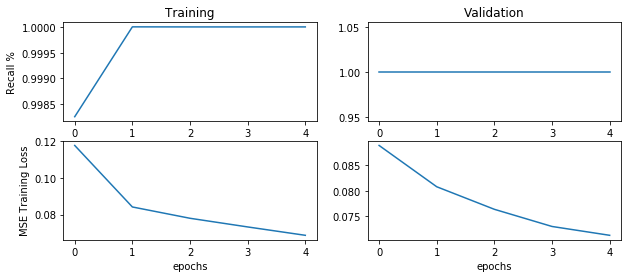

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(model_2_performance.history['recall'])
plt.ylabel('Recall %')

plt.title('Training')
plt.subplot(2,2,2)
plt.plot(model_2_performance.history['val_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(model_2_performance.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(model_2_performance.history['val_loss'])
plt.xlabel('epochs')

In [27]:
def cross_val_keras(num_layers, cv):
    for train_index, test_index in cv.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_shuffle_train, X_shuffle_test = X.iloc[train_index], X.iloc[test_index]
        y_shuffle_train, y_shuffle_test = y[train_index], y[test_index]
        for col in numeric_headers:
            X_shuffle_train[col] = X_shuffle_train[col].astype(np.float)
            X_shuffle_test[col] = X_shuffle_test[col].astype(np.float)

            ss = StandardScaler()
            X_shuffle_train[col] = ss.fit_transform(X_shuffle_train[col].values.reshape(-1, 1))
            X_shuffle_test[col] = ss.transform(X_shuffle_test[col].values.reshape(-1, 1))

        X_shuffle_train_num =  X_shuffle_train[['amount', 'oldbalanceOrg', 'oldbalanceDest']].values
        X_shuffle_test_num = X_shuffle_test[['amount', 'oldbalanceOrg', 'oldbalanceDest']].values
        X_shuffle_ints_train, X_shuffle_ints_test = get_x_ints(crossed_product_sets_2, X_shuffle_train, X_shuffle_test)
        X_shuffle_ints_train.append(X_shuffle_train_num)
        print(X_shuffle_ints_train[1].shape)
        X_shuffle_ints_test.append(X_shuffle_test_num)
        shuffle_network = KerasClassifier(build_fn=create_model,
                            crossed_columns=crossed_product_sets_2,
                            num_deep_layers=num_layers,
                            X_train=X_shuffle_train,
                            X_test=X_shuffle_test,
                            epochs=5, 
                            batch_size=100,
                            verbose=1,)
        shuffle_network.fit(X_shuffle_ints_train, y_shuffle_train)

In [28]:
cross_val_keras(2, cv)

TRAIN: [52231 61442 71554 ... 37166 60257 66636] TEST: [68061 20678 32932 ... 62321  4693 33268]


C:\Users\mayam\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

(64581,)
Deep 1 created
Deep 2 created
Epoch 1/5
64581/64581 [==============================] - 4s 56us/step - loss: 1.1820 - recall: 0.9985 - acc: 0.0016
Epoch 2/5
64581/64581 [==============================] - 3s 41us/step - loss: 1.0279 - recall: 1.0000 - acc: 0.0015
Epoch 3/5
64581/64581 [==============================] - 3s 41us/step - loss: 1.0151 - recall: 1.0000 - acc: 0.0015
Epoch 4/5
64581/64581 [==============================] - 3s 40us/step - loss: 1.0101 - recall: 1.0000 - acc: 0.0015
Epoch 5/5
64581/64581 [==============================] - 3s 42us/step - loss: 1.0073 - recall: 1.0000 - acc: 0.0015
TRAIN: [ 6503 38798 37206 ... 67539 11416  2553] TEST: [59160 44082 59591 ... 46029  9375 49952]
(64581,)
Deep 1 created
Deep 2 created
Epoch 1/5
64581/64581 [==============================] - 4s 62us/step - loss: 1.1595 - recall: 0.9985 - acc: 0.0015
Epoch 2/5
64581/64581 [==============================] - 3s 42us/step - loss: 1.0255 - recall: 1.0000 - acc: 0.0015
Epoch 3/5
645

In [29]:
cross_val_keras(3, cv)

TRAIN: [52231 61442 71554 ... 37166 60257 66636] TEST: [68061 20678 32932 ... 62321  4693 33268]


C:\Users\mayam\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

(64581,)
Deep 1 created
Deep 2 created
Deep 3 created
Epoch 1/5
64581/64581 [==============================] - 5s 72us/step - loss: 1.2016 - recall: 0.9985 - acc: 0.0016
Epoch 2/5
64581/64581 [==============================] - 3s 52us/step - loss: 1.0303 - recall: 1.0000 - acc: 0.0015
Epoch 3/5
64581/64581 [==============================] - 3s 47us/step - loss: 1.0163 - recall: 1.0000 - acc: 0.0015
Epoch 4/5
64581/64581 [==============================] - 3s 46us/step - loss: 1.0108 - recall: 1.0000 - acc: 0.0015
Epoch 5/5
64581/64581 [==============================] - 4s 54us/step - loss: 1.0079 - recall: 1.0000 - acc: 0.0015
TRAIN: [ 6503 38798 37206 ... 67539 11416  2553] TEST: [59160 44082 59591 ... 46029  9375 49952]
(64581,)
Deep 1 created
Deep 2 created
Deep 3 created
Epoch 1/5
64581/64581 [==============================] - 5s 73us/step - loss: 1.1385 - recall: 0.9985 - acc: 0.0016
Epoch 2/5
64581/64581 [==============================] - 3s 45us/step - loss: 1.0227 - recall: 1.00